In [1]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta

# Example: small subset of S&P 500 for demonstration; replace with full list as needed
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META']

end_date = datetime.today()
start_date = end_date - timedelta(days=5*365)

# Download data with all columns
raw_data = yf.download(tickers, start=start_date, end=end_date, interval='1d')

# Extract Close prices from the MultiIndex columns
data = raw_data.xs('Close', axis=1, level=0)

# Ensure datetime index and ticker columns
data.index = pd.to_datetime(data.index)
data = data.sort_index()

# Handle missing data by forward fill, then backward fill for leading NAs
data = data.ffill().bfill()

# Display the cleaned DataFrame
data.head()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  5 of 5 completed


Ticker,AAPL,AMZN,GOOGL,META,MSFT
Date,,,,,
2020-11-09,113.341736,157.186996,87.467728,277.062042,209.397842
2020-11-10,113.000694,151.751007,86.290848,270.760803,202.321732
2020-11-11,116.430557,156.869507,86.763100,274.786041,207.633636
2020-11-12,116.157753,155.514008,86.544106,273.394623,206.569351
2020-11-13,116.206467,156.440506,88.006004,275.253174,207.595276


In [2]:
# 1. Remove stocks with >10% missing data (done before fill, so reload raw data)
raw_data = yf.download(tickers, start=start_date, end=end_date, interval='1d')
close = raw_data['Close']

# Calculate % missing per ticker
missing_pct = close.isna().mean()
filtered_tickers = missing_pct[missing_pct <= 0.10].index.tolist()

# Filter data and forward/backward fill as before
data = close[filtered_tickers].ffill().bfill()

# 2. Normalize prices (divide by first non-NA value per column)
normalized_data = data / data.iloc[0]

# 3. Align all time series to the same date index (already aligned by pandas)
aligned_data = normalized_data.copy()

# 4. Filter out stocks with low average daily volume (<1M shares)
vol_data = raw_data['Volume'][filtered_tickers].ffill().bfill()
avg_volume = vol_data.mean()
liquid_tickers = avg_volume[avg_volume >= 1_000_000].index.tolist()

# Final filtered normalized price data
final_data = aligned_data[liquid_tickers]

final_data.head()

[*********************100%***********************]  5 of 5 completed


Ticker,AAPL,AMZN,GOOGL,META,MSFT
Date,,,,,
2020-11-09,1.000000,1.000000,1.000000,1.000000,1.000000
2020-11-10,0.996991,0.965417,0.986545,0.977257,0.966207
2020-11-11,1.027253,0.997980,0.991944,0.991785,0.991575
2020-11-12,1.024845,0.989357,0.989440,0.986763,0.986492
2020-11-13,1.025275,0.995251,1.006154,0.993471,0.991392


In [3]:
from statsmodels.tsa.stattools import adfuller
import numpy as np

def hurst_exponent(time_series):
    """Returns the Hurst Exponent of the time series"""
    lags = range(2, 20)
    tau = [np.sqrt(np.std(np.subtract(time_series[lag:], time_series[:-lag]))) for lag in lags]
    poly = np.polyfit(np.log(lags), np.log(tau), 1)
    return 2.0 * poly[0]

results = []
for ticker in final_data.columns:
    series = final_data[ticker].dropna()
    adf_result = adfuller(series)
    p_value = adf_result[1]
    hurst = hurst_exponent(series.values)
    
    if p_value < 0.05 and hurst < 0.5:
        results.append({'Ticker': ticker, 'ADF p-value': p_value, 'Hurst Exponent': hurst})

# Display tickers passing both stationarity (ADF) and Hurst (<0.5) filter
import pandas as pd
mean_reverting_stocks = pd.DataFrame(results)
mean_reverting_stocks

""


In [4]:
import numpy as np
import pandas as pd

signals = {}
window = 60  # Lookback window for mean & std

for ticker in final_data.columns:
    price = final_data[ticker]
    # Calculate rolling mean and std for z-score
    rolling_mean = price.rolling(window=window).mean()
    rolling_std = price.rolling(window=window).std()
    zscore = (price - rolling_mean) / rolling_std

    # Signal logic: 1=Long, -1=Short, 0=Exit/No position
    signal = np.where(zscore < -1, 1,        # Long entry
             np.where(zscore > 1, -1,        # Short entry
             np.where(np.abs(zscore) < 0.01, 0, np.nan)))  # Exit (close to 0)
    
    # Forward-fill signals; reset to 0 on each exit
    signal_series = pd.Series(signal, index=price.index)
    # Carry forward the last position until an exit occurs
    signal_ffill = signal_series.replace(0, np.nan).ffill().fillna(0)
    # If signal is 0 at any time, flat (exit)
    signal_ffill[signal_series == 0] = 0

    signals[ticker] = signal_ffill

signals_df = pd.DataFrame(signals)
signals_df.tail()  # Display the last few signals for inspection

,AAPL,AMZN,GOOGL,META,MSFT
Date,,,,,
2025-10-31,-1.0,-1.0,-1.0,1.0,-1.0
2025-11-03,-1.0,-1.0,-1.0,1.0,-1.0
2025-11-04,-1.0,-1.0,-1.0,1.0,-1.0
2025-11-05,-1.0,-1.0,-1.0,1.0,-1.0
2025-11-06,-1.0,-1.0,-1.0,1.0,1.0


In [5]:
import numpy as np
import pandas as pd

initial_capital = 1_000_000
transaction_cost = 0.001  # 0.1% per trade
slippage = 0.0005         # 0.05% per trade
allocation_per_stock = 1.0 / len(final_data.columns)  # Equal-weight for demonstration

# Align signals to avoid lookahead bias: today's position = yesterday's signal
positions = signals_df.shift(1).fillna(0)

# Track all relevant metrics
daily_returns = pd.DataFrame(index=final_data.index, columns=final_data.columns, dtype=float)
pnl = pd.Series(index=final_data.index, dtype=float)
cash = pd.Series(index=final_data.index, dtype=float)
cap = initial_capital

# Store previous positions and prices for turnover calculations
prev_pos = pd.Series(0, index=final_data.columns)  # Previous position (in units)
prev_px = pd.Series(np.nan, index=final_data.columns)

# Calculate per-stock capital to allocate
capital_per_stock = initial_capital * allocation_per_stock

for date in final_data.index:
    current_prices = final_data.loc[date]
    current_signals = positions.loc[date]

    # Calculate desired position (in dollars), then number of shares
    desired_dollar_exposure = capital_per_stock * current_signals
    desired_shares = desired_dollar_exposure / current_prices

    # Calculate turnover: position change in shares
    turnover = (desired_shares - prev_pos).abs()
    # Transaction costs and slippage applied to gross notional turnover
    cost = np.sum(turnover * current_prices * (transaction_cost + slippage))

    # Calculate daily return for each stock (mark-to-market)
    stock_return = (current_prices / prev_px - 1).replace([np.inf, -np.inf], 0)
    stock_return = stock_return.fillna(0)
    daily_pos_value = prev_pos * prev_px
    realized_pnl = np.sum(daily_pos_value * stock_return)

    # For first day, avoid nan in returns
    if date == final_data.index[0]:
        realized_pnl = 0
        cost = 0

    # Update capital net of costs
    cap = cap + realized_pnl - cost
    cash[date] = cap
    pnl[date] = cap - initial_capital

    # Update daily returns for analysis
    daily_returns.loc[date] = stock_return

    # Store current positions/prices for next day
    prev_pos = desired_shares
    prev_px = current_prices

result = pd.DataFrame({
    'Capital': cash,
    'PnL': pnl,
})
result['Daily Return'] = result['Capital'].pct_change().fillna(0)

# Display performance summary
display(result.tail())
print(f"Total Return: {result['Capital'][-1]/initial_capital - 1:.2%}")
print(f"Annualized Volatility: {result['Daily Return'].std() * np.sqrt(252):.2%}")
print(f"Sharpe Ratio: {result['Daily Return'].mean() / result['Daily Return'].std() * np.sqrt(252):.2f}")

,Capital,PnL,Daily Return
Date,,,
2025-10-31,335099.434525,-664900.565475,0.055692
2025-11-03,338683.096655,-661316.903345,0.010694
2025-11-04,343754.866694,-656245.133306,0.014975
2025-11-05,343619.009024,-656380.990976,-0.000395
2025-11-06,347901.134636,-652098.865364,0.012462


Total Return: -65.21%
Annualized Volatility: 36.04%
Sharpe Ratio: -0.41


C:\Users\hp952\AppData\Local\Temp\ipykernel_18976\3987108823.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Total Return: {result['Capital'][-1]/initial_capital - 1:.2%}")


In [6]:
import numpy as np
import pandas as pd

def compute_performance_metrics(price_series, signal_series, initial_cap=1_000_000, transaction_cost=0.001, slippage=0.0005):
    # Align signals to avoid lookahead bias
    positions = signal_series.shift(1).fillna(0)
    daily_returns = price_series.pct_change().fillna(0)

    # Calculate per-trade PnL
    trade_entries = positions.diff().abs() > 0  # points where position changes
    trade_dates = positions[trade_entries].index

    # Transaction costs for changes in position
    turnover = positions.diff().abs().fillna(0)
    costs = turnover * price_series * (transaction_cost + slippage)
    adj_daily_returns = positions * daily_returns - costs / initial_cap

    cum_returns = (1 + adj_daily_returns).cumprod()
    total_return = cum_returns.iloc[-1] - 1

    # CAGR
    n_years = (price_series.index[-1] - price_series.index[0]).days / 365.25
    cagr = cum_returns.iloc[-1]**(1/n_years) - 1

    # Sharpe Ratio
    sharpe = adj_daily_returns.mean() / adj_daily_returns.std() * np.sqrt(252)

    # Max Drawdown
    running_max = cum_returns.cummax()
    drawdown = (cum_returns - running_max) / running_max
    max_drawdown = drawdown.min()

    # Win Rate (fraction of positive trades)
    trades = positions.diff().fillna(0) != 0  # Entry/Exit points
    trade_starts = trade_dates[::2] if len(trade_dates) % 2 == 0 else trade_dates[:-1:2]
    trade_ends   = trade_dates[1::2]
    wins = 0
    durations = []
    n_trades = len(trade_starts)
    for entry, exit in zip(trade_starts, trade_ends):
        entry_idx = price_series.index.get_loc(entry)
        exit_idx = price_series.index.get_loc(exit)
        # Trade direction: long or short
        pos = signal_series.loc[entry]
        entry_px = price_series.loc[entry]
        exit_px = price_series.loc[exit]
        ret = (exit_px - entry_px)/entry_px if pos > 0 else (entry_px - exit_px)/entry_px
        if ret > 0:
            wins += 1
        durations.append(exit_idx - entry_idx)
    win_rate = wins / n_trades if n_trades > 0 else np.nan
    avg_trade_duration = np.mean(durations) if durations else np.nan

    return {
        'CAGR': cagr,
        'Sharpe': sharpe,
        'Max Drawdown': max_drawdown,
        'Win Rate': win_rate,
        'Avg Trade Duration': avg_trade_duration,
        'Total Return': total_return
    }

perf = {}
for col in final_data.columns:
    metrics = compute_performance_metrics(final_data[col], signals_df[col])
    perf[col] = metrics

# Display performance comparison DataFrame
perf_df = pd.DataFrame(perf).T
perf_df = perf_df[['Total Return', 'CAGR', 'Sharpe', 'Max Drawdown', 'Win Rate', 'Avg Trade Duration']]
perf_df.style.format({
    'Total Return': '{:.2%}',
    'CAGR': '{:.2%}',
    'Sharpe': '{:.2f}',
    'Max Drawdown': '{:.2%}',
    'Win Rate': '{:.2%}',
    'Avg Trade Duration': '{:.1f}'
})

,Total Return,CAGR,Sharpe,Max Drawdown,Win Rate,Avg Trade Duration
AAPL,-28.81%,-6.58%,-0.11,-54.94%,40.00%,42.5
AMZN,-29.30%,-6.71%,-0.03,-64.24%,54.55%,67.8
GOOGL,-72.39%,-22.73%,-0.71,-72.87%,55.56%,76.8
META,-89.19%,-35.97%,-0.82,-91.35%,63.64%,38.3
MSFT,-9.22%,-1.92%,0.05,-38.55%,60.00%,48.7


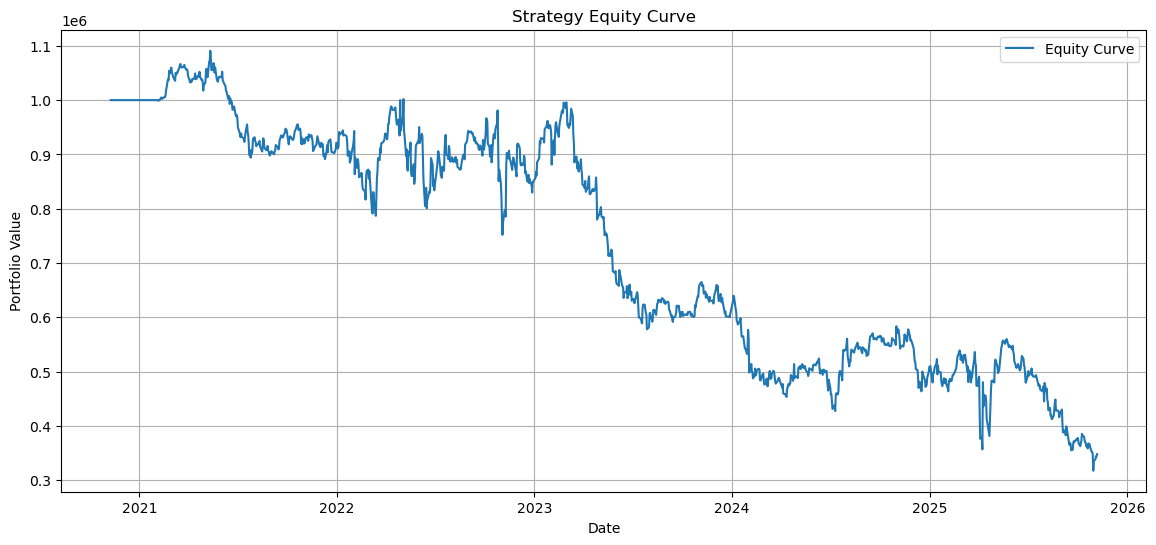

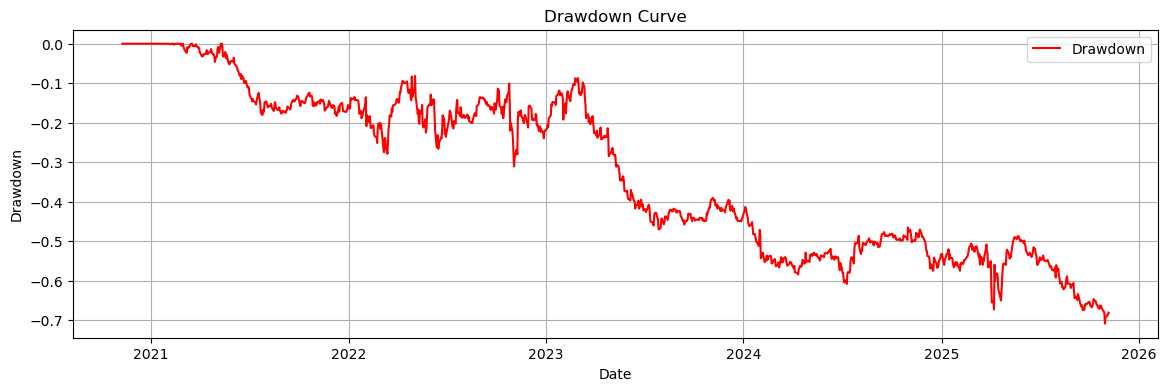

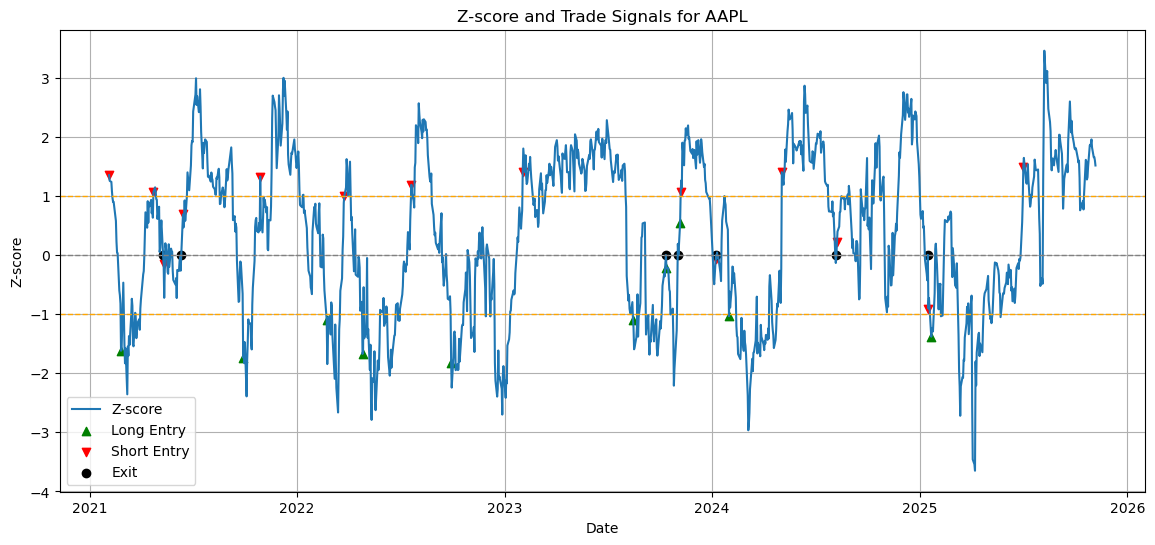

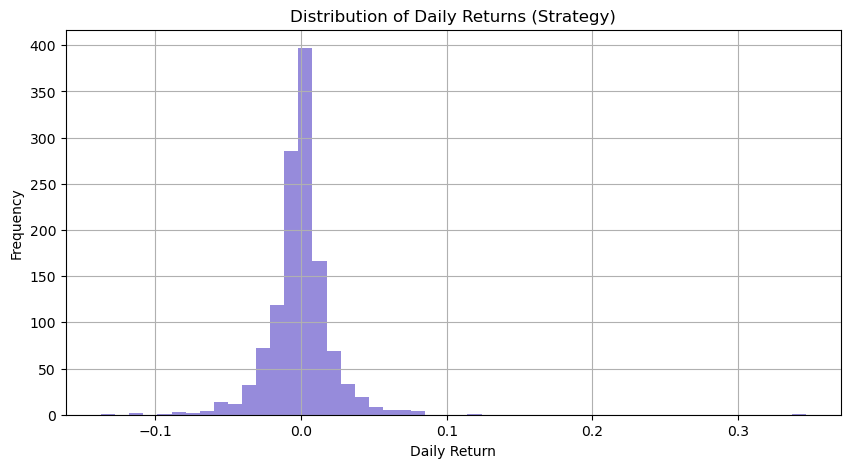

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Equity curve
plt.figure(figsize=(14, 6))
plt.plot(result.index, result['Capital'], label='Equity Curve')
plt.title('Strategy Equity Curve')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.grid(True)
plt.show()

# 2. Drawdown curve
cum_max = result['Capital'].cummax()
drawdown = (result['Capital'] - cum_max) / cum_max

plt.figure(figsize=(14, 4))
plt.plot(result.index, drawdown, color='red', label='Drawdown')
plt.title('Drawdown Curve')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.legend()
plt.grid(True)
plt.show()

# 3. Z-score with entry/exit points for 'AAPL'
ticker = 'AAPL'
price = final_data[ticker]
window = 60
rolling_mean = price.rolling(window=window).mean()
rolling_std = price.rolling(window=window).std()
zscore = (price - rolling_mean) / rolling_std
signal = signals_df[ticker]

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(zscore.index, zscore, label='Z-score')
# Mark long/short entry points
long_entries = (signal == 1) & (signal.shift(1) != 1)
short_entries = (signal == -1) & (signal.shift(1) != -1)
exit_points = (signal == 0) & (signal.shift(1) != 0)

ax.scatter(zscore.index[long_entries], zscore[long_entries], marker='^', color='g', label='Long Entry')
ax.scatter(zscore.index[short_entries], zscore[short_entries], marker='v', color='r', label='Short Entry')
ax.scatter(zscore.index[exit_points], zscore[exit_points], marker='o', color='black', label='Exit')
ax.axhline(0, linestyle='--', color='gray', linewidth=1)
ax.axhline(1, linestyle='--', color='orange', linewidth=1)
ax.axhline(-1, linestyle='--', color='orange', linewidth=1)
ax.set_title(f'Z-score and Trade Signals for {ticker}')
ax.set_xlabel('Date')
ax.set_ylabel('Z-score')
ax.legend()
ax.grid(True)
plt.show()

# 4. Distribution of daily returns
plt.figure(figsize=(10, 5))
plt.hist(result['Daily Return'], bins=50, color='slateblue', alpha=0.7)
plt.title('Distribution of Daily Returns (Strategy)')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [8]:

trade_log = []

for ticker in final_data.columns:
    price = final_data[ticker]
    signals = signals_df[ticker]
    position = 0
    entry_date = None
    entry_price = None
    entry_signal = None
    for i in range(1, len(signals)):
        prev_sig = signals.iloc[i-1]
        curr_sig = signals.iloc[i]
        # Detect entry
        if position == 0 and curr_sig in [1, -1]:
            position = curr_sig
            entry_date = signals.index[i]
            entry_price = price.iloc[i]
            entry_signal = curr_sig
        # Detect exit (position closed)
        elif position != 0 and (curr_sig != position):
            exit_date = signals.index[i]
            exit_price = price.iloc[i]
            size = entry_signal  # +1 for long, -1 for short
            # P&L calculation (long: exit-entry, short: entry-exit)
            if entry_signal == 1:
                pnl = (exit_price - entry_price) / entry_price
            elif entry_signal == -1:
                pnl = (entry_price - exit_price) / entry_price
            else:
                pnl = 0
            holding_period = (exit_date - entry_date).days
            trade_log.append({
                'Ticker': ticker,
                'Entry Date': entry_date,
                'Entry Price': entry_price,
                'Exit Date': exit_date,
                'Exit Price': exit_price,
                'Position': 'Long' if size == 1 else 'Short',
                'P&L (%)': pnl * 100,
                'Holding Period (Days)': holding_period
            })
            # Reset position
            position = 0
            entry_date = None
            entry_price = None
            entry_signal = None

# Save to DataFrame and CSV
trades_df = pd.DataFrame(trade_log)
trades_df = trades_df.sort_values(['Entry Date', 'Ticker']).reset_index(drop=True)
trades_df.to_csv('trade_log.csv', index=False)
display(trades_df.head())

,Ticker,Entry Date,Entry Price,Exit Date,Exit Price,Position,P&L (%),Holding Period (Days)
0,AAPL,2021-02-04,1.181138,2021-02-25,1.041702,Short,11.805244,21
1,AMZN,2021-02-04,1.059566,2021-02-25,0.972460,Short,8.220955,21
2,GOOGL,2021-02-04,1.165895,2022-01-05,1.564363,Short,-34.177046,335
3,MSFT,2021-02-04,1.111056,2021-03-08,1.046341,Short,5.824681,32
4,META,2021-02-19,0.938265,2021-03-16,1.001829,Long,6.774720,25


In [9]:
import itertools
import numpy as np
import pandas as pd

# Define parameter grid
z_entry_list = [0.7, 1.0, 1.3]
z_exit_list = [0.0, 0.1, 0.2]
window_list = [40, 60, 100]
stop_list = [None, 0.03, 0.05]      # Max loss per trade (fractional)
take_list = [None, 0.04, 0.07]      # Take-profit per trade (fractional)

results = []

def run_signal_strategy(price, window, z_entry, z_exit, stop=None, take=None):
    rolling_mean = price.rolling(window=window).mean()
    rolling_std = price.rolling(window=window).std()
    zscore = (price - rolling_mean) / rolling_std

    # Signal: 1 for long, -1 for short, 0 for exit
    signal = np.where(zscore < -z_entry, 1,
             np.where(zscore > z_entry, -1,
             np.where(np.abs(zscore) < z_exit, 0, np.nan)))
    signal_series = pd.Series(signal, index=price.index)
    # Carry last signal forward until exit
    signal_final = signal_series.replace(0, np.nan).ffill().fillna(0)
    signal_final[signal_series == 0] = 0

    # Stop-loss/take-profit handling (per trade; simplistic implementation)
    position = 0
    entry_price = None
    updated_signal = signal_final.copy()
    for i in range(1, len(price)):
        if position == 0 and updated_signal.iloc[i] != 0:
            # New entry
            entry_price = price.iloc[i]
            position = updated_signal.iloc[i]
        elif position != 0:
            ret = (price.iloc[i] - entry_price) / entry_price if position == 1 else (entry_price - price.iloc[i]) / entry_price
            stop_hit = stop is not None and ret <= -stop
            take_hit = take is not None and ret >= take
            if stop_hit or take_hit:
                updated_signal.iloc[i] = 0
                position = 0
                entry_price = None
            elif updated_signal.iloc[i] == 0:
                # Regular exit
                position = 0
                entry_price = None
            else:
                updated_signal.iloc[i] = position  # stay in position
    return updated_signal

# Only run on AAPL for speed
price = final_data['AAPL']
initial_cap = 1_000_000

for (z_entry, z_exit, window, stop, take) in itertools.product(z_entry_list, z_exit_list, window_list, stop_list, take_list):
    # Skip invalid combos
    if z_exit >= z_entry:
        continue
    # Generate signals
    sigs = run_signal_strategy(price, window, z_entry, z_exit, stop, take)
    perf = compute_performance_metrics(price, sigs, initial_cap)
    results.append({
        'z_entry': z_entry,
        'z_exit': z_exit,
        'window': window,
        'stop': stop,
        'take': take,
        **perf
    })

opt_result = pd.DataFrame(results)
display(opt_result.sort_values('Sharpe', ascending=False).head(10))

# Report best parameters
best_row = opt_result.loc[opt_result['Sharpe'].idxmax()]
print("Best parameters found:")
print(best_row[['z_entry', 'z_exit', 'window', 'stop', 'take', 'Total Return', 'CAGR', 'Sharpe']])

,z_entry,z_exit,window,stop,take,CAGR,Sharpe,Max Drawdown,Win Rate,Avg Trade Duration,Total Return
72,0.7,0.2,100,NaN,NaN,0.215016,0.893247,-0.269754,0.480000,19.380000,1.643362
78,0.7,0.2,100,0.05,NaN,0.202445,0.862256,-0.253379,0.465517,16.568966,1.509654
75,0.7,0.2,100,0.03,NaN,0.194096,0.834622,-0.242471,0.469697,14.424242,1.423874
66,0.7,0.2,60,0.03,NaN,0.187569,0.799720,-0.306017,0.531646,12.367089,1.358466
157,1.0,0.2,100,0.03,0.04,0.172510,0.791502,-0.259749,0.523810,6.292517,1.212932
76,0.7,0.2,100,0.03,0.04,0.171756,0.788795,-0.259749,0.520270,6.270270,1.205840
153,1.0,0.2,100,NaN,NaN,0.180618,0.780736,-0.269754,0.420000,19.340000,1.290366
156,1.0,0.2,100,0.03,NaN,0.170721,0.755484,-0.242471,0.439394,14.378788,1.196134
27,0.7,0.1,40,NaN,NaN,0.181090,0.748610,-0.272489,0.586207,36.896552,1.294939
159,1.0,0.2,100,0.05,NaN,0.168403,0.747917,-0.281192,0.413793,16.534483,1.174514


Best parameters found:
z_entry           0.700000
z_exit            0.200000
window          100.000000
stop                   NaN
take                   NaN
Total Return      1.643362
CAGR              0.215016
Sharpe            0.893247
Name: 72, dtype: float64


In [10]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

class DataFetcher:
    """
    Handles data fetching and preprocessing from Yahoo Finance.
    """
    def __init__(self, tickers, start, end, interval='1d'):
        self.tickers = tickers
        self.start = start
        self.end = end
        self.interval = interval

    def fetch(self):
        df = yf.download(self.tickers, start=self.start, end=self.end, interval=self.interval)
        close = df['Close']
        volume = df['Volume']
        close = close.ffill().bfill()
        volume = volume.ffill().bfill()
        return close, volume

    def clean(self, close, volume, max_na_pct=0.1, min_avg_vol=1_000_000):
        # Remove tickers with too much missing data (before fill)
        miss_pct = close.isna().mean()
        filtered = miss_pct[miss_pct <= max_na_pct].index.tolist()
        close = close[filtered]
        volume = volume[filtered]
        # Remove illiquid stocks
        avg_vol = volume.mean()
        liquid = avg_vol[avg_vol >= min_avg_vol].index.tolist()
        final_close = close[liquid]
        final_volume = volume[liquid]
        return final_close, final_volume

class ZScoreSignalGenerator:
    """
    Generates trading signals based on rolling z-score.
    """
    def __init__(self, window=60, z_entry=1, z_exit=0.0):
        self.window = window
        self.z_entry = z_entry
        self.z_exit = z_exit

    def generate(self, price_series):
        mean = price_series.rolling(self.window).mean()
        std = price_series.rolling(self.window).std()
        zscore = (price_series - mean) / std
        # 1=long, -1=short, 0=exit
        signal = np.where(zscore < -self.z_entry, 1,
                 np.where(zscore > self.z_entry, -1,
                 np.where(np.abs(zscore) < self.z_exit, 0, np.nan)))
        signal_series = pd.Series(signal, index=price_series.index)
        # Hold positions until exit
        sig_ffill = signal_series.replace(0, np.nan).ffill().fillna(0)
        sig_ffill[signal_series == 0] = 0
        return sig_ffill

class Backtester:
    """
    Runs a simple backtest on provided signals and price series.
    """
    def __init__(self, initial_capital=1_000_000, transaction_cost=0.001, slippage=0.0005):
        self.initial_capital = initial_capital
        self.transaction_cost = transaction_cost
        self.slippage = slippage

    def run(self, price, signals):
        positions = signals.shift(1).fillna(0)
        daily_returns = price.pct_change().fillna(0)
        turnover = positions.diff().abs().fillna(0)
        costs = turnover * price * (self.transaction_cost + self.slippage) / self.initial_capital
        strategy_returns = positions * daily_returns - costs
        capital_curve = (1 + strategy_returns).cumprod() * self.initial_capital
        return pd.DataFrame({
            'Capital': capital_curve,
            'Strategy Return': strategy_returns
        })

class PerformanceAnalyzer:
    """
    Evaluates performance of a strategy.
    """
    def __init__(self, capital_curve, strat_returns, freq=252):
        self.capital_curve = capital_curve
        self.strat_returns = strat_returns
        self.freq = freq

    def metrics(self):
        total_ret = self.capital_curve.iloc[-1]/self.capital_curve.iloc[0] - 1
        n_years = (self.capital_curve.index[-1] - self.capital_curve.index[0]).days / 365.25
        cagr = (self.capital_curve.iloc[-1] / self.capital_curve.iloc[0])**(1/n_years) - 1
        ann_vol = self.strat_returns.std() * np.sqrt(self.freq)
        sharpe = self.strat_returns.mean() / self.strat_returns.std() * np.sqrt(self.freq)
        drawdown = (self.capital_curve / self.capital_curve.cummax()) - 1
        max_drawdown = drawdown.min()
        return {
            'Total Return': total_ret,
            'CAGR': cagr,
            'Ann Volatility': ann_vol,
            'Sharpe': sharpe,
            'Max Drawdown': max_drawdown,
        }

# Example usage
if __name__ == '__main__':
    tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META']
    end = datetime.today()
    start = end - timedelta(days=5*365)
    fetcher = DataFetcher(tickers, start, end)
    close, volume = fetcher.fetch()
    close, volume = fetcher.clean(close, volume)

    generator = ZScoreSignalGenerator(window=60, z_entry=1, z_exit=0.0)
    signals = {t: generator.generate(close[t]) for t in close.columns}
    signals_df = pd.DataFrame(signals)

    bt = Backtester()
    # For one stock, AAPL as example
    aapl_result = bt.run(close['AAPL'], signals_df['AAPL'])
    analyzer = PerformanceAnalyzer(aapl_result['Capital'], aapl_result['Strategy Return'])
    print(analyzer.metrics())

[*********************100%***********************]  5 of 5 completed

{'Total Return': -0.27973743635435977, 'CAGR': -0.06363029091364758, 'Ann Volatility': 0.27374810168565566, 'Sharpe': -0.10432904309160873, 'Max Drawdown': -0.5360209745328179}


In [11]:
# Advanced Enhancements: PCA/Kalman Pair Selection, Walk-Forward, Streamlit Dashboard

import numpy as np
import pandas as pd
from sklearn.decomposition import PCA

# --- 1. Dynamic pair selection using PCA ---
def get_pca_spread(data, n_components=2):
    # Assume standardized input
    pca = PCA(n_components=n_components)
    components = pca.fit_transform(data)
    # Use first two PCs to reconstruct synthetic pairs
    pc_df = pd.DataFrame(components, index=data.index, columns=[f'PC{i+1}' for i in range(n_components)])
    # Construct pair as difference of PC1 and PC2
    spread = pc_df['PC1'] - pc_df['PC2']
    return spread, pc_df, pca

# --- 2. Walk-forward validation ---
def walk_forward_optimization(data, signal_func, perf_func, window_train=252*2, window_test=252, **signal_kwargs):
    """ Split data into rolling train/test, optimize on train, evaluate on test, slide forward. """
    results = []
    starts = range(0, len(data) - window_train - window_test + 1, window_test)
    for s in starts:
        train_idx = slice(s, s+window_train)
        test_idx = slice(s+window_train, s+window_train+window_test)
        train = data.iloc[train_idx]
        test = data.iloc[test_idx]
        # Optimize parameters on train (simple version: fixed params passed)
        signal = signal_func(train, **signal_kwargs)
        # Assume same params for test (could grid-search train here)
        test_signal = signal_func(test, **signal_kwargs)
        metrics = perf_func(test, test_signal)
        results.append(metrics)
    return pd.DataFrame(results)

# --- 3. Streamlit dashboard for interactive testing ---
def run_streamlit_advanced(final_data):
    try:
        import streamlit as st
    except ModuleNotFoundError:
        print("Streamlit not installed. Please install it to run this dashboard.")
        return

    st.title("Advanced Mean Reversion Strategy (PCA/WF) Explorer")
    method = st.radio("Spread Computation", ['PCA (min-variance spread)', 'Simple Pair'])
    if method == 'PCA (min-variance spread)':
        n_comp = st.slider('Number of PCA Components', 2, min(5, len(final_data.columns)), 2)
        st.write("PCA is performed across all input tickers. Spread = PC1 - PC2.")
        spread, pc_df, pca = get_pca_spread(final_data, n_comp)
        st.line_chart(spread.rename("PCA Spread"))
    else:
        ticker1 = st.selectbox("Ticker 1", final_data.columns)
        ticker2 = st.selectbox("Ticker 2", [t for t in final_data.columns if t != ticker1])
        spread = final_data[ticker1] - final_data[ticker2]
        st.line_chart(spread.rename(f'{ticker1}-{ticker2} Spread'))

    # Signal parameters
    window = st.slider("Rolling Window", 20, 120, 60)
    z_entry = st.slider("Z-Entry Threshold", 0.5, 2.0, 1.0, 0.05)
    z_exit = st.slider("Z-Exit Threshold", 0.0, 1.0, 0.1)
    walk = st.checkbox("Walk-forward Validation", value=False)

    def zscore_signal(prices, window=60, z_entry=1.0, z_exit=0.0):
        mean = prices.rolling(window).mean()
        std = prices.rolling(window).std()
        z = (prices - mean) / std
        sig = np.where(z < -z_entry, 1, np.where(z > z_entry, -1, np.where(np.abs(z) < z_exit, 0, np.nan)))
        sig_series = pd.Series(sig, index=prices.index)
        sig_ffill = sig_series.replace(0, np.nan).ffill().fillna(0)
        sig_ffill[sig_series == 0] = 0
        return sig_ffill

    def perf(prices, signals):
        positions = signals.shift(1).fillna(0)
        ret = prices.pct_change().fillna(0)
        strat = positions * ret
        cap = (1 + strat).cumprod()
        sharpe = strat.mean() / strat.std() * np.sqrt(252)
        maxdd = (cap / cap.cummax() - 1).min()
        return {'Sharpe': sharpe, 'TotRet': cap.iloc[-1]/cap.iloc[0]-1, 'MaxDD': maxdd}

    if not walk:
        sig = zscore_signal(spread, window, z_entry, z_exit)
        pos = sig.shift(1).fillna(0)
        rets = spread.pct_change().fillna(0)
        strat_rets = pos * rets
        cap = (1 + strat_rets).cumprod()
        st.line_chart(cap.rename("Cumulative Return"))
        metrics = perf(spread, sig)
        st.write(f"Sharpe Ratio: {metrics['Sharpe']:.2f}, Total Return: {metrics['TotRet']:.2%}, Max Drawdown: {metrics['MaxDD']:.2%}")
    else:
        wf_summary = walk_forward_optimization(spread, zscore_signal, perf, window_train=252*2, window_test=252,
                                              window=window, z_entry=z_entry, z_exit=z_exit)
        st.dataframe(wf_summary)
        st.write("Average Out-of-Sample Sharpe: ", wf_summary["Sharpe"].mean().round(2))

# Only run Streamlit if requested
if __name__ == '__main__' and False:
    run_streamlit_advanced(final_data)

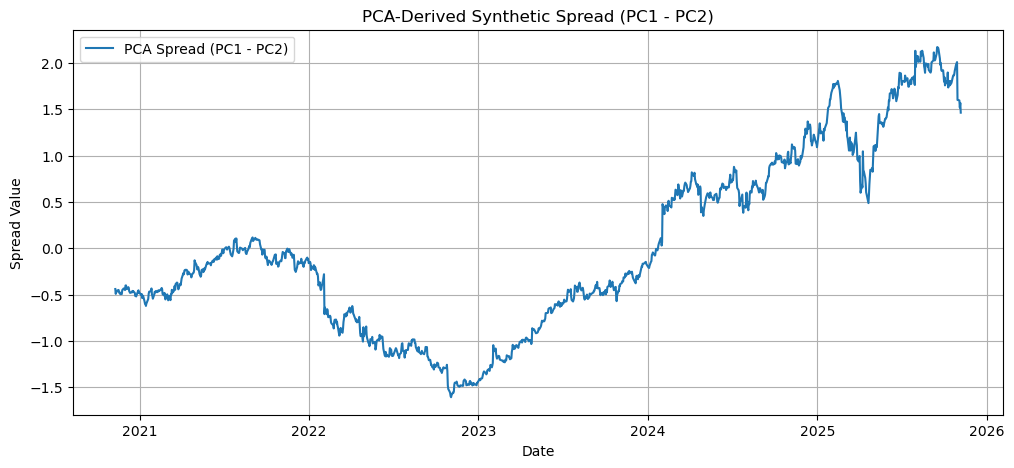

Explained variance ratio (by PC): [0.91225096 0.0498733 ]


,Total Return,CAGR,Ann Volatility,Sharpe,Max Drawdown
0,-0.051203,-0.051238,0.783457,0.335631,-0.636962
1,1.436683,1.426356,1.170213,1.334284,-0.632445


Mean Out-of-Sample Sharpe: 0.8349575002078771


In [12]:
import matplotlib.pyplot as plt

# Run a core part of the advanced enhancements: PCA spread on 'final_data' with visualization

# (1) Compute and plot the PCA spread
spread, pc_df, pca = get_pca_spread(final_data, n_components=2)

plt.figure(figsize=(12,5))
plt.plot(spread.index, spread, label='PCA Spread (PC1 - PC2)')
plt.title('PCA-Derived Synthetic Spread (PC1 - PC2)')
plt.xlabel('Date')
plt.ylabel('Spread Value')
plt.legend()
plt.grid(True)
plt.show()

# (2) Show PCA explained variance (which components capture the most variance)
print("Explained variance ratio (by PC):", pca.explained_variance_ratio_)

# (3) Run a quick walk-forward validation on the PCA spread using the provided z-score signal/perf
wf_df = walk_forward_optimization(
    spread,
    signal_func=lambda series, **kwargs: ZScoreSignalGenerator(**kwargs).generate(series),
    perf_func=lambda prices, signals: PerformanceAnalyzer(
        (1 + (signals.shift(1).fillna(0) * prices.pct_change().fillna(0))).cumprod(), 
        signals.shift(1).fillna(0) * prices.pct_change().fillna(0)
    ).metrics(),
    window_train=252*2,
    window_test=252,
    window=60,
    z_entry=1.0,
    z_exit=0.1
)
display(wf_df)
print("Mean Out-of-Sample Sharpe:", wf_df['Sharpe'].mean())